# 🎯 Uplift modeling `metrics` advanced

<br>
<center>
    <a href="https://colab.research.google.com/github/maks-sh/scikit-uplift/blob/master/notebooks/uplift_metrics_tutorial_advanced.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg">
    </a>
    <br>
    <b><a href="https://github.com/maks-sh/scikit-uplift/">SCIKIT-UPLIFT REPO</a> | </b>
    <b><a href="https://scikit-uplift.readthedocs.io/en/latest/">SCIKIT-UPLIFT DOCS</a> | </b>
    <b><a href="https://scikit-uplift.readthedocs.io/en/latest/user_guide/index.html">USER GUIDE</a></b>
    <br>
</center>

In [1]:
import sys

# install uplift library scikit-uplift and other libraries 
!{sys.executable} -m pip install scikit-uplift dill catboost

# 📝 Load data

We are going to use a `Lenta dataset` from the BigTarget Hackathon hosted in summer 2020 by Lenta and Microsoft.

Lenta is a russian food retailer. 

### Data description

✏️ Dataset can be loaded from `sklift.datasets` module using `fetch_lenta` function.

Read more about dataset <a href="https://www.uplift-modeling.com/en/latest/api/datasets/fetch_lenta.html">in the api docs</a>.  

This is an uplift modeling dataset containing data about Lenta's customers grociery shopping, marketing campaigns communications as `treatment` and store visits as `target`.

####  ✏️ Major columns:

- `group` - treatment / control flag
- `response_att` - binary target
- `CardHolder` - customer id
- `gender` - customer gender 
- `age` - customer age

In [2]:
from sklift.datasets import fetch_lenta

# returns sklearn Bunch object
# with data, target, treatment keys
# data features (pd.DataFrame), target (pd.Series), treatment (pd.Series) values 
dataset = fetch_lenta()

In [3]:
print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

Dataset type: <class 'sklearn.utils.Bunch'>

Dataset features shape: (687029, 193)
Dataset target shape: (687029,)
Dataset treatment shape: (687029,)


# 📝 EDA

In [4]:
dataset.data.head().append(dataset.data.tail())

,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,cheque_count_12m_g42,cheque_count_12m_g45,cheque_count_12m_g46,cheque_count_12m_g48,cheque_count_12m_g52,cheque_count_12m_g56,cheque_count_12m_g57,cheque_count_12m_g58,cheque_count_12m_g79,cheque_count_3m_g20,cheque_count_3m_g21,cheque_count_3m_g25,cheque_count_3m_g42,cheque_count_3m_g45,cheque_count_3m_g52,cheque_count_3m_g56,cheque_count_3m_g57,cheque_count_3m_g79,cheque_count_6m_g20,cheque_count_6m_g21,cheque_count_6m_g25,cheque_count_6m_g32,cheque_count_6m_g33,cheque_count_6m_g38,cheque_count_6m_g39,cheque_count_6m_g40,cheque_count_6m_g41,cheque_count_6m_g42,cheque_count_6m_g45,cheque_count_6m_g46,cheque_count_6m_g48,...,perdelta_days_between_visits_15_30d,promo_share_15d,response_sms,response_viber,sale_count_12m_g32,sale_count_12m_g33,sale_count_12m_g49,sale_count_12m_g54,sale_count_12m_g57,sale_count_3m_g24,sale_count_3m_g33,sale_count_3m_g57,sale_count_6m_g24,sale_count_6m_g25,sale_count_6m_g32,sale_count_6m_g33,sale_count_6m_g44,sale_count_6m_g54,sale_count_6m_g57,sale_sum_12m_g24,sale_sum_12m_g25,sale_sum_12m_g26,sale_sum_12m_g27,sale_sum_12m_g32,sale_sum_12m_g44,sale_sum_12m_g54,sale_sum_3m_g24,sale_sum_3m_g26,sale_sum_3m_g32,sale_sum_3m_g33,sale_sum_6m_g24,sale_sum_6m_g25,sale_sum_6m_g26,sale_sum_6m_g32,sale_sum_6m_g33,sale_sum_6m_g44,sale_sum_6m_g54,stdev_days_between_visits_15d,stdev_discount_depth_15d,stdev_discount_depth_1m
0,47.0,3.0,22.0,19.0,3.0,28.0,8.0,7.0,6.0,1.0,13.0,12.0,16.0,3.0,15.0,11.0,0.0,4.0,0.0,7.0,8.0,0.0,5.0,1.0,6.0,6.0,1.0,0.0,12.0,9.0,1.0,6.0,4.0,2.0,5.0,1.0,0.0,5.0,5.0,6.0,...,1.3393,0.5821,0.923077,0.071429,10.0,84.314,98.0,16.0,11.0,137.282,28.776,6.0,169.658,10.680,7.0,28.776,21.0,8.0,9.0,4469.86,658.85,1286.32,7736.05,418.80,3233.31,811.73,2321.61,182.82,283.84,3648.23,3141.25,356.67,237.25,283.84,3648.23,1195.37,535.42,1.7078,0.2798,0.3008
1,57.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,3.0,1.0,0.0,1.0,0.0,1.0,...,0.0000,0.0000,1.000000,0.000000,1.0,1.000,2.0,2.0,0.0,0.000,1.000,0.0,1.744,2.000,1.0,1.000,0.0,2.0,0.0,113.39,62.69,58.71,93.35,87.01,0.00,122.98,0.00,58.71,87.01,179.83,113.39,62.69,58.71,87.01,179.83,0.00,122.98,0.0000,0.0000,0.0000
2,38.0,7.0,0.0,15.0,4.0,9.0,5.0,9.0,14.0,7.0,6.0,10.0,14.0,5.0,11.0,0.0,3.0,2.0,2.0,0.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,6.0,0.0,9.0,2.0,5.0,1.0,7.0,7.0,8.0,3.0,2.0,6.0,6.0,...,0.0000,0.7256,1.000000,0.250000,5.0,21.102,50.0,109.0,0.0,0.000,7.594,0.0,25.294,11.084,3.0,11.158,31.0,59.0,0.0,1564.91,971.09,177.93,3257.49,975.21,2555.27,6351.29,0.00,0.00,0.00,783.87,1239.19,533.46,83.37,593.13,1217.43,1336.83,3709.82,0.0000,NaN,0.0803
3,65.0,6.0,3.0,25.0,2.0,10.0,14.0,11.0,8.0,1.0,0.0,2.0,6.0,7.0,2.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,11.0,2.0,3.0,5.0,5.0,4.0,2.0,1.0,0.0,1.0,3.0,...,0.0000,0.0000,0.909091,0.000000,2.0,12.544,49.0,39.0,0.0,0.000,2.778,0.0,2.000,34.212,2.0,3.778,2.0,13.0,0.0,358.22,3798.18,680.93,1425.07,175.73,602.81,3544.76,0.00,119.99,73.24,346.74,139.68,1849.91,360.40,175.73,496.73,172.58,1246.21,0.0000,0.0000,0.0000
4,61.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,3.0,2.0,1.0,1.0,5.0,5.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,8.0,2.0,2.0,1.0,1.0,4.0,...,0.0000,0.7865,1.000000,0.100000,0.0,1.454,25.0,25.0,0.0,0.000,0.454,0.0,3.036,12.000,0.0,1.454,8.0,23.0,0.0,226.98,168.05,960.37,1560.21,0.00,342.45,1039.85,0.00,66.18,0.00,87.94,226.98,168.05,461.37,0.00,237.93,225.51,995.27,1.4142,0.3495,0.3495
687024,35.0,0.0,0.0,4.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,2.0,3.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,5.0,0.0,2.0,2.0,2.0,2.0,...,1.3333,0.4002,0.000000,0.166667,0.0,3.000,14.0,2.0,0.0,19.856,3.000,0.0,19.856,29.000,0.0,3.000,15.0,1.0,0.0,550.09,695.32,111.87,114.21,0.00,1173.84,147.68,550.09,111

### 🤔 target share for `treatment / control` 

In [5]:
import pandas as pd 

pd.crosstab(dataset.treatment, dataset.target, normalize='index')

response_att,0,1
group,,
control,0.897421,0.102579
test,0.889874,0.110126


In [6]:
# make treatment binary
treat_dict = {
    'test': 1,
    'control': 0
}

dataset.treatment = dataset.treatment.map(treat_dict)

In [7]:
# fill NaNs in the categorical feature `gender` 
# for CatBoostClassifier
dataset.data['gender'] = dataset.data['gender'].fillna(value='Не определен')

print(dataset.data['gender'].value_counts(dropna=False))

Ж               433448
М               243910
Не определен      9671
Name: gender, dtype: int64


### ✂️ train test split

- stratify by two columns: treatment and target. 

`Intuition:` In a binary classification problem definition we stratify train set by splitting target `0/1` column. In uplift modeling we have two columns instead of one. 

In [8]:
from sklearn.model_selection import train_test_split

stratify_cols = pd.concat([dataset.treatment, dataset.target], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    dataset.data,
    dataset.treatment,
    dataset.target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (480920, 193)
Validation shape: (206109, 193)


# 👾 Class Transformation uplift model

`Class transformation` method is described <a href="https://www.uplift-modeling.com/en/latest/user_guide/models/revert_label.html"> here</a>  

Class transormation method `may` be used in case of treatment unbalanced data. In this case one will get not an uplift score but some *ranking* score still useful for ranking objects.

In [9]:
from sklift.models import ClassTransformation
from catboost import CatBoostClassifier

estimator = CatBoostClassifier(verbose=100, 
                               cat_features=['gender'],
                               random_state=42,
                               thread_count=1)

ct_model = ClassTransformation(estimator=estimator)

In [10]:
ct_model.fit(
    X=X_train, 
    y=y_train, 
    treatment=trmnt_train
)

Learning rate set to 0.143939
0:	learn: 0.6685632	total: 1.08s	remaining: 18m 1s
100:	learn: 0.5948982	total: 1m 21s	remaining: 12m 8s
200:	learn: 0.5907078	total: 2m 40s	remaining: 10m 37s
300:	learn: 0.5869612	total: 3m 58s	remaining: 9m 14s
400:	learn: 0.5835421	total: 5m 18s	remaining: 7m 55s
500:	learn: 0.5801981	total: 6m 36s	remaining: 6m 35s
600:	learn: 0.5769677	total: 7m 56s	remaining: 5m 16s
700:	learn: 0.5737862	total: 9m 17s	remaining: 3m 57s
800:	learn: 0.5706947	total: 10m 39s	remaining: 2m 38s
900:	learn: 0.5677056	total: 11m 59s	remaining: 1m 19s
999:	learn: 0.5648107	total: 13m 16s	remaining: 0us


ClassTransformation(estimator=<catboost.core.CatBoostClassifier object at 0x7f40d5a7d790>)

### Save model

In [11]:
import dill

with open("model.dill", 'wb') as f:
    dill.dump(ct_model, f)

### Uplift prediction

In [12]:
uplift_ct_val = ct_model.predict(X_val)
uplift_ct_train = ct_model.predict(X_train)

# 🚀🚀🚀 Uplift metrics

##  🚀 `uplift@k`

- uplift at first k%
- usually falls between [0; 1] depending on k, model quality and data


### `uplift@k` = `target mean at k% in the treatment group` - `target mean at k% in the control group`

___

How to count `uplift@k`:

1. sort by predicted uplift
2. select first k%
3. count target mean in the treatment group
4. count target mean in the control group
5. substract the mean in the control group from the mean in the treatment group

---

Code parameter options:

- `strategy='overall'` - sort by uplift treatment and control together
- `strategy='by_group'` - sort by uplift treatment and control separately

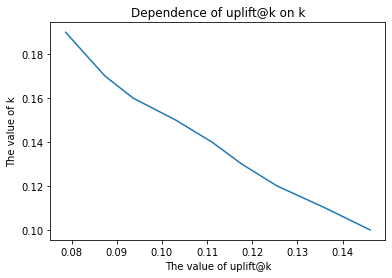

In [13]:
from sklift.metrics import uplift_at_k
import matplotlib.pyplot as plt

# k = 10%
k = 0.1
delta = 0.01

values_uplift_k = []
values_k = []
for i in range(10):
  values_uplift_k.append(uplift_at_k(y_val, uplift_ct_val, trmnt_val, strategy='overall', k=k))
  values_k.append(k)
  k += delta

plt.plot(values_uplift_k,values_k)
plt.title('Dependence of uplift@k on k')
plt.xlabel('The value of uplift@k')
plt.ylabel('The value of k')
plt.show()

# 🚀 `ASD metric`
### `The average squared deviation (ASD) is a model stability metric that shows how much the model overfits *the* training data. Larger values of ASD mean greater overfit.`

In [14]:
from sklift.metrics import average_squared_deviation

asd_overall = average_squared_deviation(y_train, uplift_ct_train, trmnt_train, y_val, uplift_ct_val, trmnt_val, strategy='overall')
asd_by_group = average_squared_deviation(y_train, uplift_ct_train, trmnt_train, y_val, uplift_ct_val, trmnt_val, strategy='by_group')

print(f"average squared deviation by overall strategy: {asd_overall:.4f}")
print(f"average squared deviation by group strategy: {asd_by_group:.4f}")

average squared deviation by overall strategy: 0.0143
average squared deviation by group strategy: 0.0120


# `Display 2 different model uplift scores on one qini plot`

In [20]:
from sklift.models import TwoModels
from sklift.models import ClassTransformation
from catboost import CatBoostClassifier

first_estimator = CatBoostClassifier(verbose=100,
                               cat_features=['gender'],
                               random_state=42,
                               thread_count=1)
second_estimator = CatBoostClassifier(verbose=100,
                               cat_features=['gender'],
                               random_state=42,
                               thread_count=1)
transform_model = ClassTransformation(estimator=first_estimator)
two_model = TwoModels(estimator_trmnt=first_estimator, estimator_ctrl=second_estimator)

In [21]:
transform_model = transform_model.fit(
    X=X_train, 
    y=y_train, 
    treatment=trmnt_train
)

two_model = two_model.fit(
    X=X_train, 
    y=y_train, 
    treatment=trmnt_train
)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.143939
0:	learn: 0.6685632	total: 922ms	remaining: 15m 20s
100:	learn: 0.5948982	total: 1m 22s	remaining: 12m 16s
200:	learn: 0.5907078	total: 2m 41s	remaining: 10m 42s
300:	learn: 0.5869612	total: 4m	remaining: 9m 17s
400:	learn: 0.5835421	total: 5m 20s	remaining: 7m 58s
500:	learn: 0.5801981	total: 6m 39s	remaining: 6m 38s
600:	learn: 0.5769677	total: 8m	remaining: 5m 19s
700:	learn: 0.5737862	total: 9m 22s	remaining: 3m 59s
800:	learn: 0.5706947	total: 10m 43s	remaining: 2m 39s
900:	learn: 0.5677056	total: 12m 4s	remaining: 1m 19s
999:	learn: 0.5648107	total: 13m 23s	remaining: 0us
Learning rate set to 0.079511
0:	learn: 0.6127627	total: 245ms	remaining: 4m 4s
100:	learn: 0.2654049	total: 24.2s	remaining: 3m 35s
200:	learn: 0.2583688	total: 47.3s	remaining: 3m 7s
300:	learn: 0.2511464	total: 1m 10s	remaining: 2m 43s
400:	learn: 0.2446533	total: 1m 33s	remaining: 2m 20s
500:	learn: 0.2384005	total: 1m 57s	remaining: 1m 56s
600:	learn: 0.2323947	total: 2m 20s	re

In [24]:
uplift_transform_model = transform_model.predict(X_val)
uplift_two_model = two_model.predict(X_val)

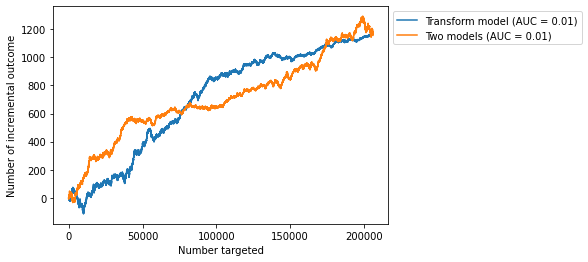

In [25]:
from sklift.viz import plot_qini_curve

fig, ax_roc = plt.subplots(1, 1)
plot_qini_curve(y_val, uplift_transform_model, trmnt_val, name='Transform model', random=False, perfect=False, ax=ax_roc)
plot_qini_curve(y_val, uplift_two_model, trmnt_val, name='Two models', random=False, perfect=False, ax=ax_roc)